In [142]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


In [143]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [144]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions,plot_xgb_feature_importance


In [145]:
sheet = pd.read_excel('data_input/沪铝期货价格.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['沪铝期货价格'].last_valid_index()
# 获取last_day之后的数据
future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.head()

,沪铝期货价格,铝现货进口升贴水,LME铜价,沪铝月差/连1-连3,铝社会库存（锭+棒）(处理预测短期)超季节性/3年,LME铝升贴水/0-3/5DMA,美国成屋销售/折年数/季调同比,美国经济惊喜指数,美国零售销售月环比
1992-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1992-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.3
1992-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8
1992-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3
1992-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5


In [146]:
sheet.columns

Index(['沪铝期货价格', '铝现货进口升贴水', 'LME铜价', '沪铝月差/连1-连3',
       '铝社会库存（锭+棒）(处理预测短期)超季节性/3年', 'LME铝升贴水/0-3/5DMA', '美国成屋销售/折年数/季调同比',
       '美国经济惊喜指数', '美国零售销售月环比'],
      dtype='object')

In [147]:
# 尝试多个可能的文件路径
file_paths1 = [
    os.path.expanduser("~/Desktop/X-BASE/铜/eta/LME铜价_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/铜/eta/LME铜价_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/铜/eta/LME铜价_合并数据.xlsx")
]

file_path1 = None
for path1 in file_paths1:
    if os.path.isfile(path1):  # 确保是文件而不是目录
        file_path1 = path1
        break

if file_path1 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet1 = pd.read_excel(file_path1, sheet_name='Sheet1')
    sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
    sheet1 = sheet1.drop(columns=['真实值'])
    sheet1 = sheet1.dropna()
    sheet1 = sheet1.sort_values('Date', ascending=True)
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet1.head()

,Date,预测值
20,2025-11-03,10914.4
19,2025-11-04,10961.7
18,2025-11-05,10958.2
17,2025-11-06,10954.0
16,2025-11-07,10954.8


In [148]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['LME铜价'] = sheet_daily['LME铜价'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')

In [149]:
fill_methods = {
    '铝现货进口升贴水': 'interpolate',
    'LME铜价': 'interpolate', 
    '沪铝月差/连1-连3': 'interpolate',
    '铝社会库存（锭+棒）(处理预测短期)超季节性/3年': 'interpolate', 
    'LME铝升贴水/0-3/5DMA': 'interpolate',
    '美国成屋销售/折年数/季调同比': 'interpolate',
    '美国经济惊喜指数': 'interpolate', 
    '美国零售销售月环比': 'interpolate',
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, '沪铝期货价格'] = sheet.loc[:last_day, '沪铝期货价格'].interpolate(method='linear')

sheet['铝现货进口升贴水_提前20天'] = sheet['铝现货进口升贴水'].shift(20)        
sheet['沪铝月差/连1-连3_提前45天'] = sheet['沪铝月差/连1-连3'].shift(45)
sheet['LME铝升贴水/0-3/5DMA_提前40天'] = sheet['LME铝升贴水/0-3/5DMA'].shift(40)
sheet['美国成屋销售/折年数/季调同比_提前60天'] = sheet['美国成屋销售/折年数/季调同比'].shift(60)
sheet['美国经济惊喜指数_提前20天'] = sheet['美国经济惊喜指数'].shift(20)
sheet['美国零售销售月环比_提前60天'] = sheet['美国零售销售月环比'].shift(60)


sheet['沪铝月差/连1-连3_提前45天_逆序'] = reverse_column(sheet, '沪铝月差/连1-连3_提前45天')
sheet['铝社会库存（锭+棒）(处理预测短期)超季节性/3年_逆序'] = reverse_column(sheet, '铝社会库存（锭+棒）(处理预测短期)超季节性/3年')                                   


################################# 数据筛选  #################################
# 重置索引 确保 `Date` 为 datetime 类型
sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])
# 筛选日期大于 2024-01-01 的行
sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2024-01-01')]
# 重置索引,使其从0开始 
sheet_daily = sheet_daily.reset_index(drop=True)
# 删除 在 last_day 之前 预测标的 为 空值的 行
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['沪铝期货价格'].notna())                                   
]


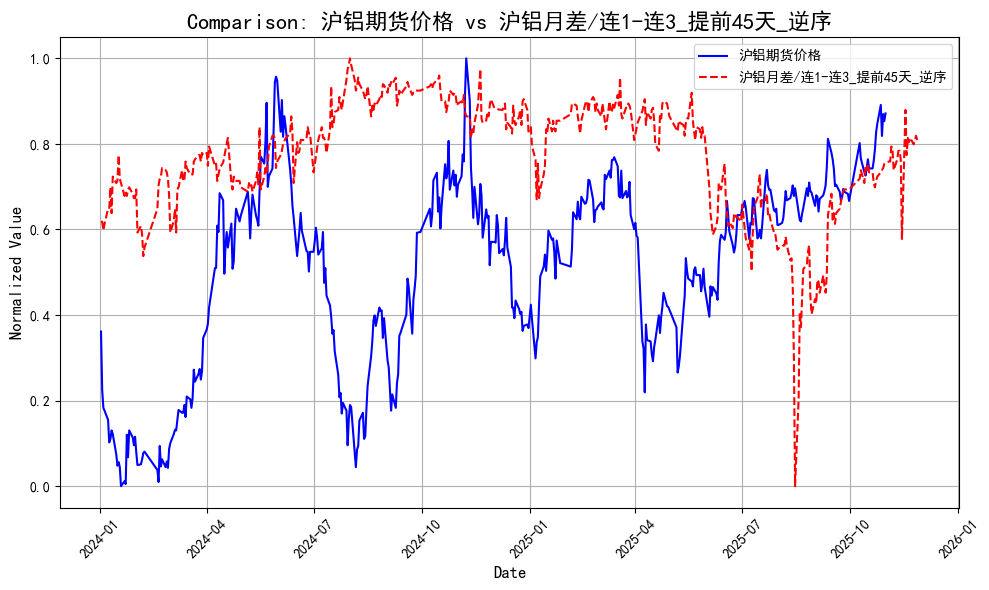

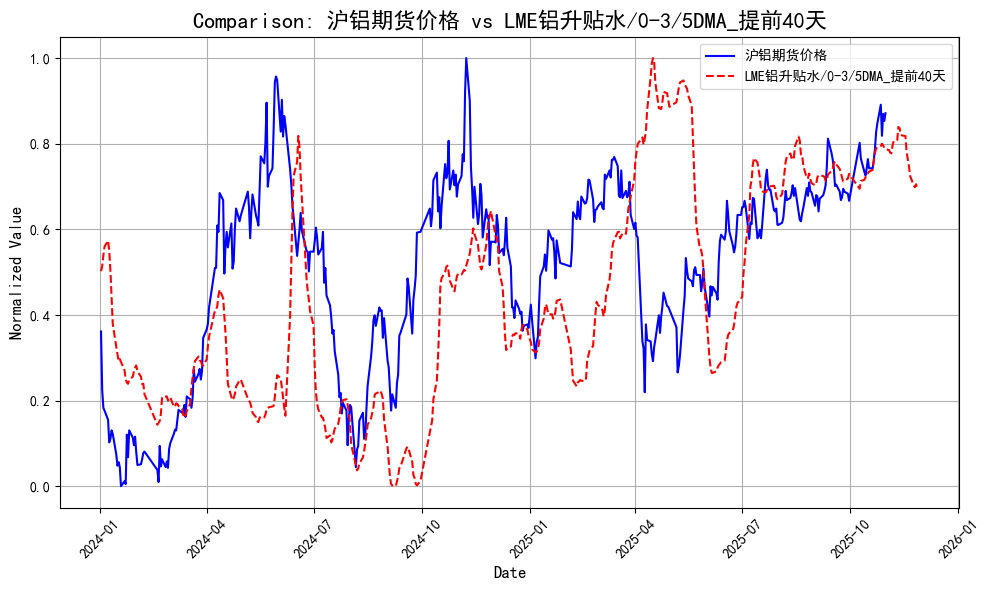

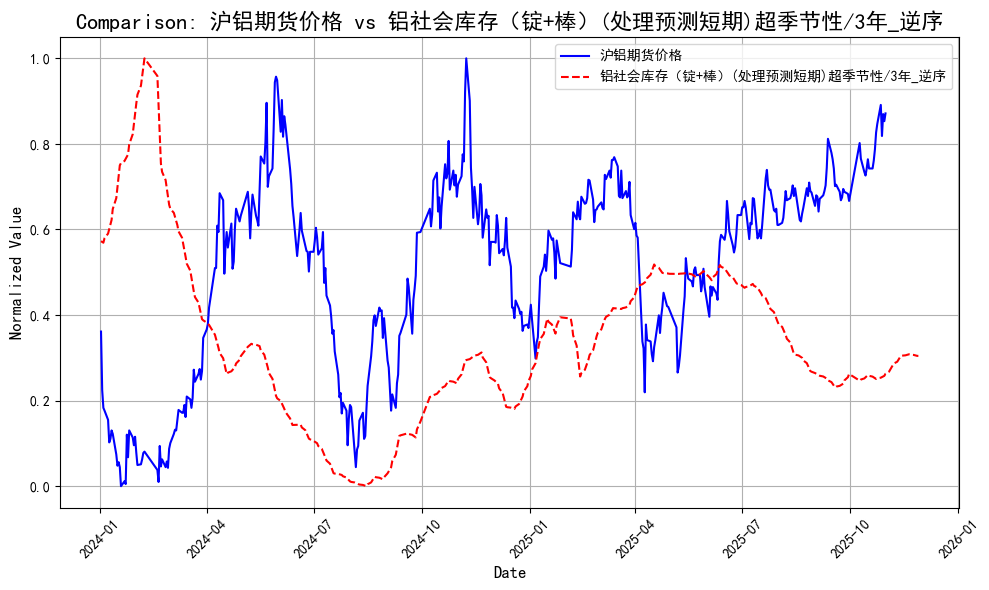

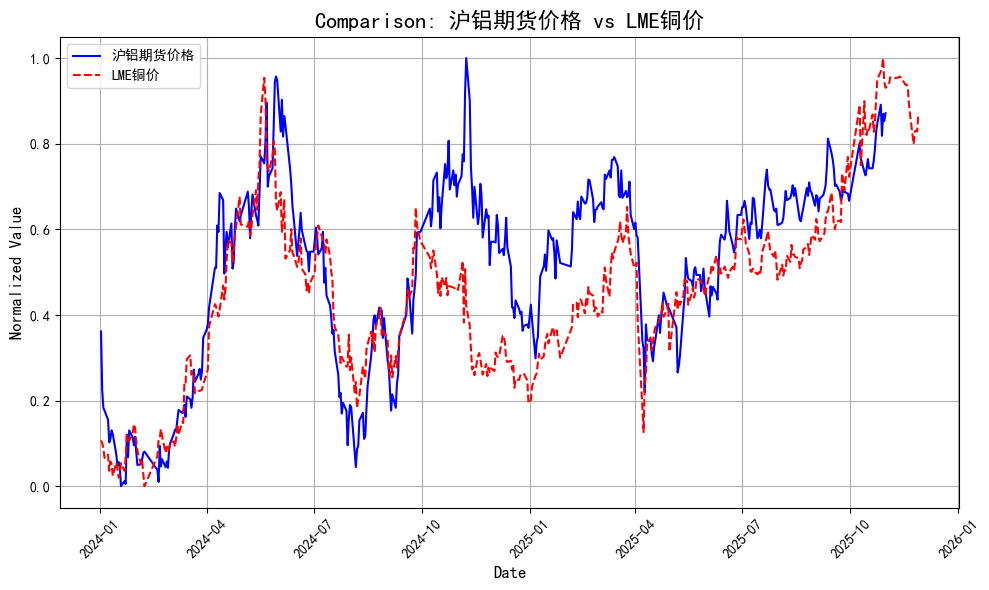

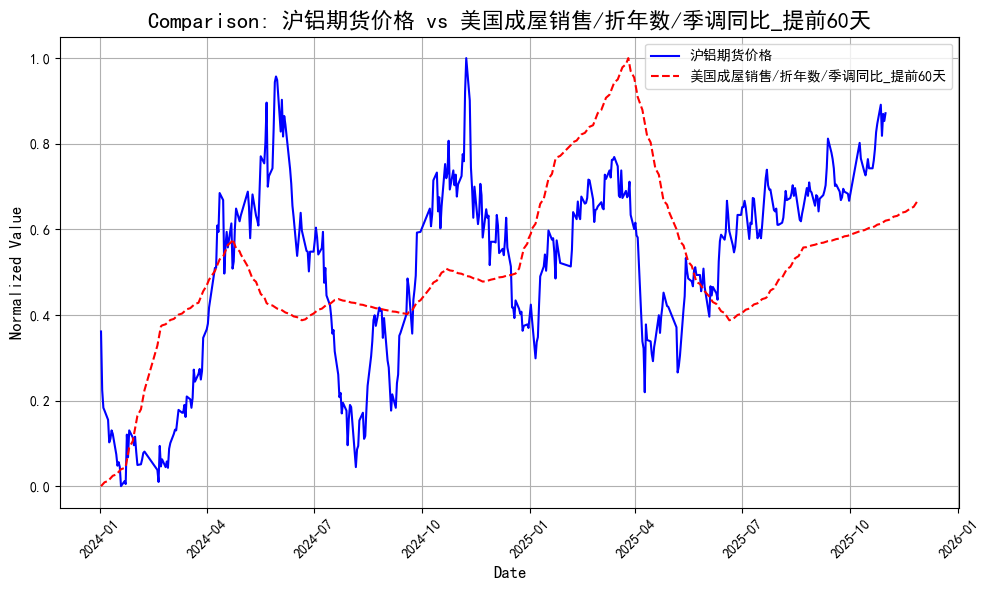

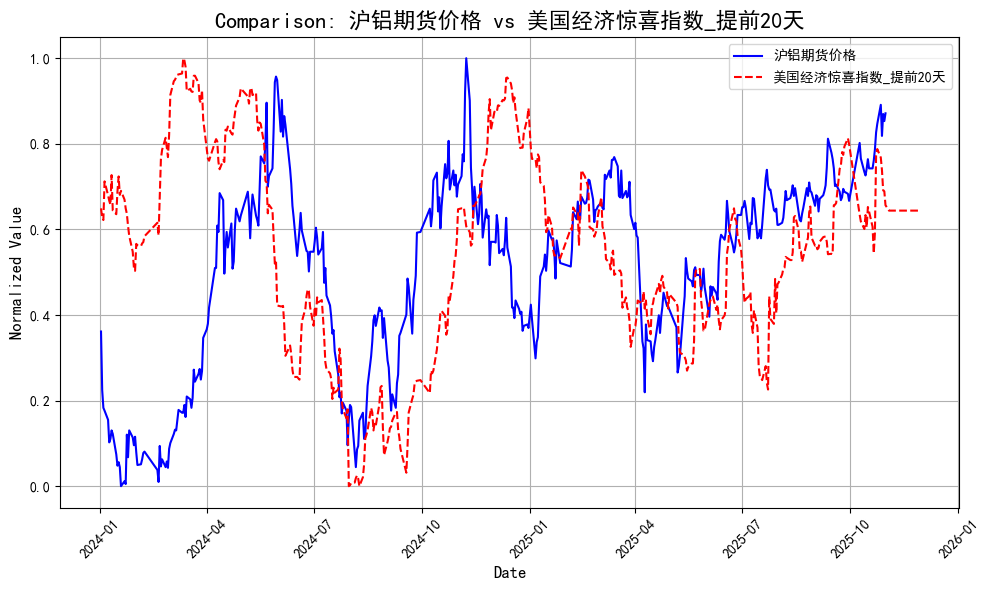

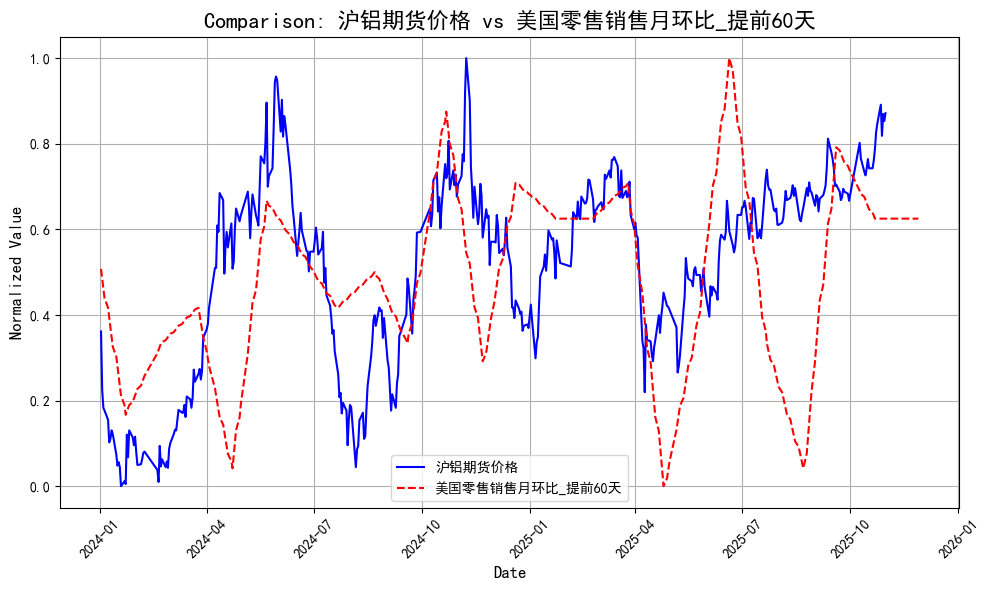

In [150]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='沪铝期货价格',   
    compare_cols=[
    #    '铝现货进口升贴水_提前20天', 
        '沪铝月差/连1-连3_提前45天_逆序', 
        'LME铝升贴水/0-3/5DMA_提前40天',
        '铝社会库存（锭+棒）(处理预测短期)超季节性/3年_逆序', 
        'LME铜价' ,        
        '美国成屋销售/折年数/季调同比_提前60天',
        '美国经济惊喜指数_提前20天',
        '美国零售销售月环比_提前60天'
        ]
)

In [151]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 15
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
    #    '铝现货进口升贴水_提前20天', 
        '沪铝月差/连1-连3_提前45天_逆序', 
        'LME铝升贴水/0-3/5DMA_提前40天',
        '铝社会库存（锭+棒）(处理预测短期)超季节性/3年_逆序', 
        'LME铜价' ,        
        '美国成屋销售/折年数/季调同比_提前60天',
        '美国经济惊喜指数_提前20天',
        '美国零售销售月环比_提前60天'
]

predict_column = '沪铝期货价格'



X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
# params = {
#     'objective': 'reg:squarederror',  # 回归任务
#     'learning_rate': 0.01,  # 较小的学习率
#     'max_depth': 8,  # 控制树的深度防止过拟合
#     'min_child_weight': 5,  # 控制过拟合
#     'subsample': 0.7,  # 随机采样防止过拟合
#     'colsample_bytree': 0.7,  # 特征随机采样
#     'gamma': 0.5,  # 控制分裂
#     'reg_alpha': 0.8,  # L1正则化
#     'reg_lambda': 0,  # L2正则化
#     'eval_metric': 'rmse', # 评估指标：选择“rmse”
#     'seed': 42, # 随机种子
# }
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.01,  # 较小的学习率
    'max_depth': 10,  # 控制树的深度防止过拟合
    'min_child_weight': 6,  # 控制过拟合
    'subsample': 0.7,  # 随机采样防止过拟合
    'colsample_bytree': 0.7,  # 特征随机采样
    'gamma': 0.6,  # 控制分裂
    'reg_alpha': 0.8,  # L1正则化
    'reg_lambda': 0.1,  # L2正则化
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
}
num_boost_round = 1000
evals_result = {}

# 模型训练
# model = xgb.train(
#     params,
#     train_dmatrix_huber,  # 使用带权重的DMatrix
#     num_boost_round, # 训练最大轮数
#     evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
#     early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
#     evals_result=evals_result,  # 保存训练过程中的评估结果
#     verbose_eval=100 # 每100轮输出一次评估信息
# )

model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=100 # 每100轮输出一次评估信息
)

y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:903.81199	train-rmse:647.99628


[100]	eval-rmse:488.94687	train-rmse:271.81420
[200]	eval-rmse:354.42233	train-rmse:133.56015
[300]	eval-rmse:314.26416	train-rmse:83.90027
[400]	eval-rmse:295.72979	train-rmse:64.10572
[500]	eval-rmse:287.92252	train-rmse:53.33539
[600]	eval-rmse:285.79939	train-rmse:45.94310
[700]	eval-rmse:284.10141	train-rmse:40.18962
[800]	eval-rmse:284.53193	train-rmse:35.76128
[900]	eval-rmse:282.11150	train-rmse:32.06637
[999]	eval-rmse:282.80418	train-rmse:28.86782
训练集 MSE (DMatrix): 867.1939, 训练集 R² (DMatrix): 0.998
测试集 MSE (DMatrix): 79978.2059, 测试集 R² (DMatrix): -1.7854


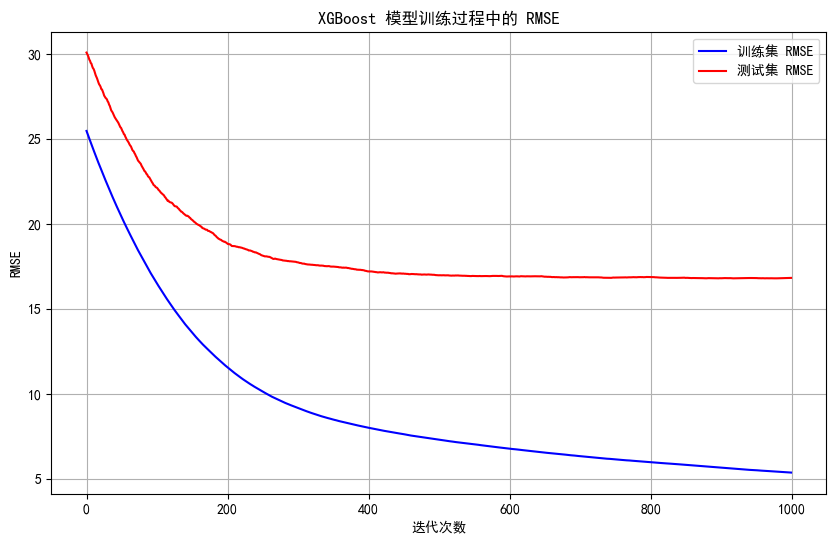

In [152]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重


# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=100
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:656.14353
[100]	train-rmse:273.81691
[200]	train-rmse:133.10329
[300]	train-rmse:83.05695
[400]	train-rmse:63.28834
[500]	train-rmse:52.79999
[600]	train-rmse:45.60864
[700]	train-rmse:40.02614
[800]	train-rmse:35.71853
[900]	train-rmse:32.07667
[999]	train-rmse:28.98126
全部数据 MSE: 870.4625, 全部数据 R²: 0.9981


In [154]:
future_data

,Date,沪铝期货价格,铝现货进口升贴水,LME铜价,沪铝月差/连1-连3,铝社会库存（锭+棒）(处理预测短期)超季节性/3年,LME铝升贴水/0-3/5DMA,美国成屋销售/折年数/季调同比,美国经济惊喜指数,美国零售销售月环比,铝现货进口升贴水_提前20天,沪铝月差/连1-连3_提前45天,LME铝升贴水/0-3/5DMA_提前40天,美国成屋销售/折年数/季调同比_提前60天,美国经济惊喜指数_提前20天,美国零售销售月环比_提前60天,沪铝月差/连1-连3_提前45天_逆序,铝社会库存（锭+棒）(处理预测短期)超季节性/3年_逆序,预测值,预测值_全量
484,2025-11-03,NaN,87.0,10914.4,-25.0,1.32314,-1.03,0.041,13.8,0.6,100.0,45.0,3.688,0.011245,13.8,0.6,1000.0,21.36686,20913.111328,21556.085938
485,2025-11-04,NaN,87.0,10961.7,-25.0,1.03826,-1.03,0.041,13.8,0.6,100.0,45.0,3.196,0.011714,13.8,0.6,1000.0,21.65174,20914.945312,21544.800781
486,2025-11-05,NaN,87.0,10958.2,-25.0,0.75338,-1.03,0.041,13.8,0.6,100.0,10.0,3.060,0.012182,13.8,0.6,1035.0,21.93662,20892.646484,21500.867188
487,2025-11-06,NaN,87.0,10954.0,-25.0,0.46850,-1.03,0.041,13.8,0.6,100.0,20.0,4.570,0.012650,13.8,0.6,1025.0,22.22150,20888.904297,21564.144531
488,2025-11-07,NaN,87.0,10954.8,-25.0,0.20688,-1.03,0.041,13.8,0.6,100.0,65.0,5.468,0.013118,13.8,0.6,980.0,22.48312,20886.732422,21533.269531
489,2025-11-10,NaN,87.0,10958.2,-25.0,-0.05474,-1.03,0.041,13.8,0.6,100.0,40.0,5.668,0.013586,13.8,0.6,1005.0,22.74474,20897.890625,21573.673828
490,2025-11-11,NaN,87.0,10960.8,-25.0,-0.31636,-1.03,0.041,13.8,0.6,99.0,20.0,8.216,0.014055,13.8,0.6,1025.0,23.00636,20882.302734,21522.816406
491,2025-11-12,NaN,87.0,10966.9,-25.0,-0.57798,-1.03,0.041,13.8,0.6,99.0,20.0,7.980,0.014523,13.8,0.6,1025.0,23.26798,20869.740234,21501.951172
492,2025-11-13,NaN,87.0,10961.7,-25.0,-0.83960,-1.03,0.041,13.8,0.6,99.0,40.0,6.746,0.014991,13.8,0.6,1005.0,23.52960,20806.156250,21419.734375
493,2025-11-14,NaN,87.0,10950.7,-25.0,-0.88666,-1.03,0.041,13.8,0.6,96.0,225.0,6.562,0.015459,13.8,0.6,820.0,23.57666,20834.888672,21401.105469


Gap between last actual value and first prediction: -256.0859375


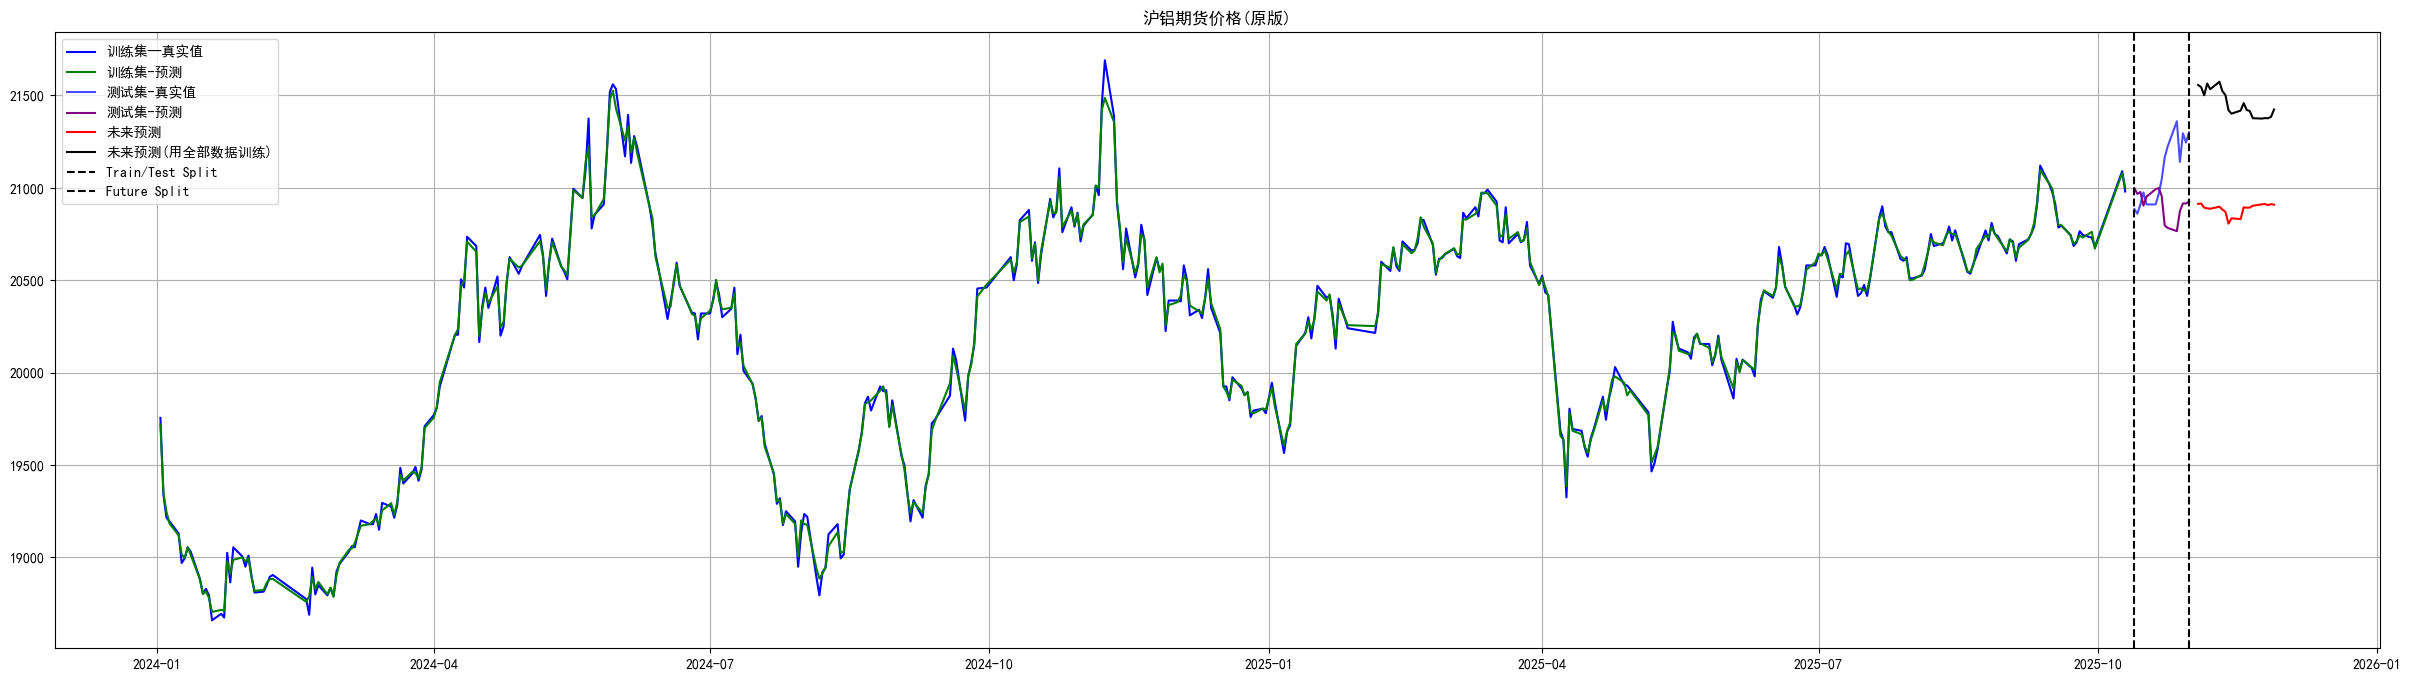

In [ ]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')


# 设置标题和图例
plt.title('沪铝期货价格(原版)')   
plt.legend()
plt.grid(True)
plt.show()


---

Gap between last actual value and first prediction: -256.0859375


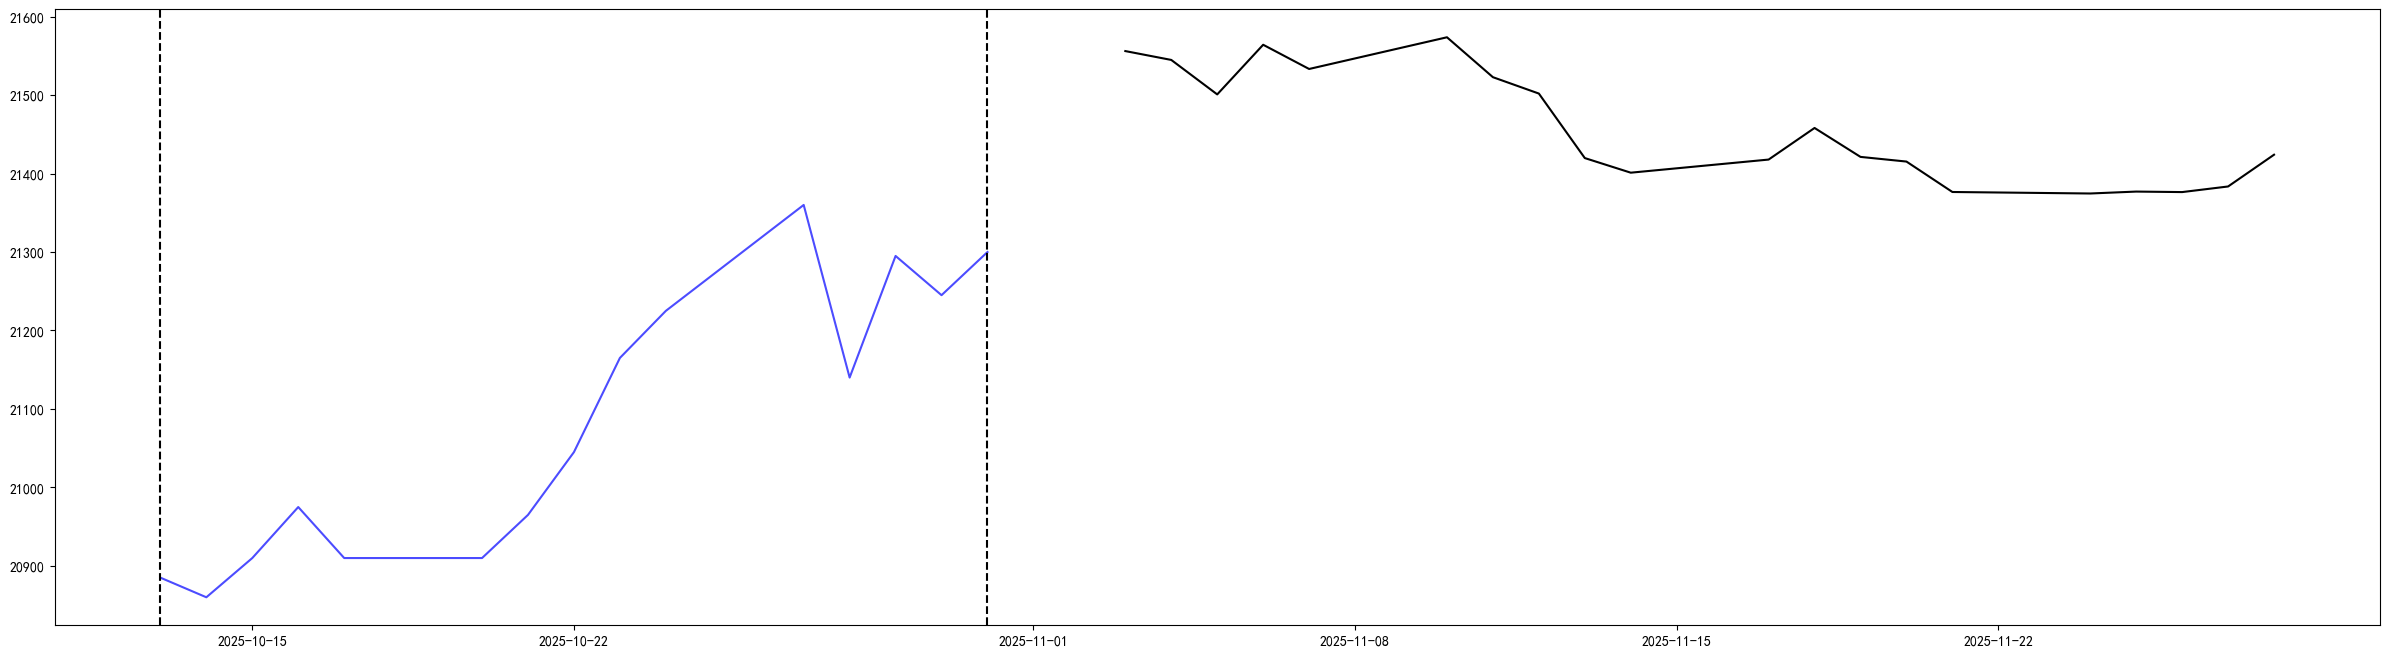

In [168]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

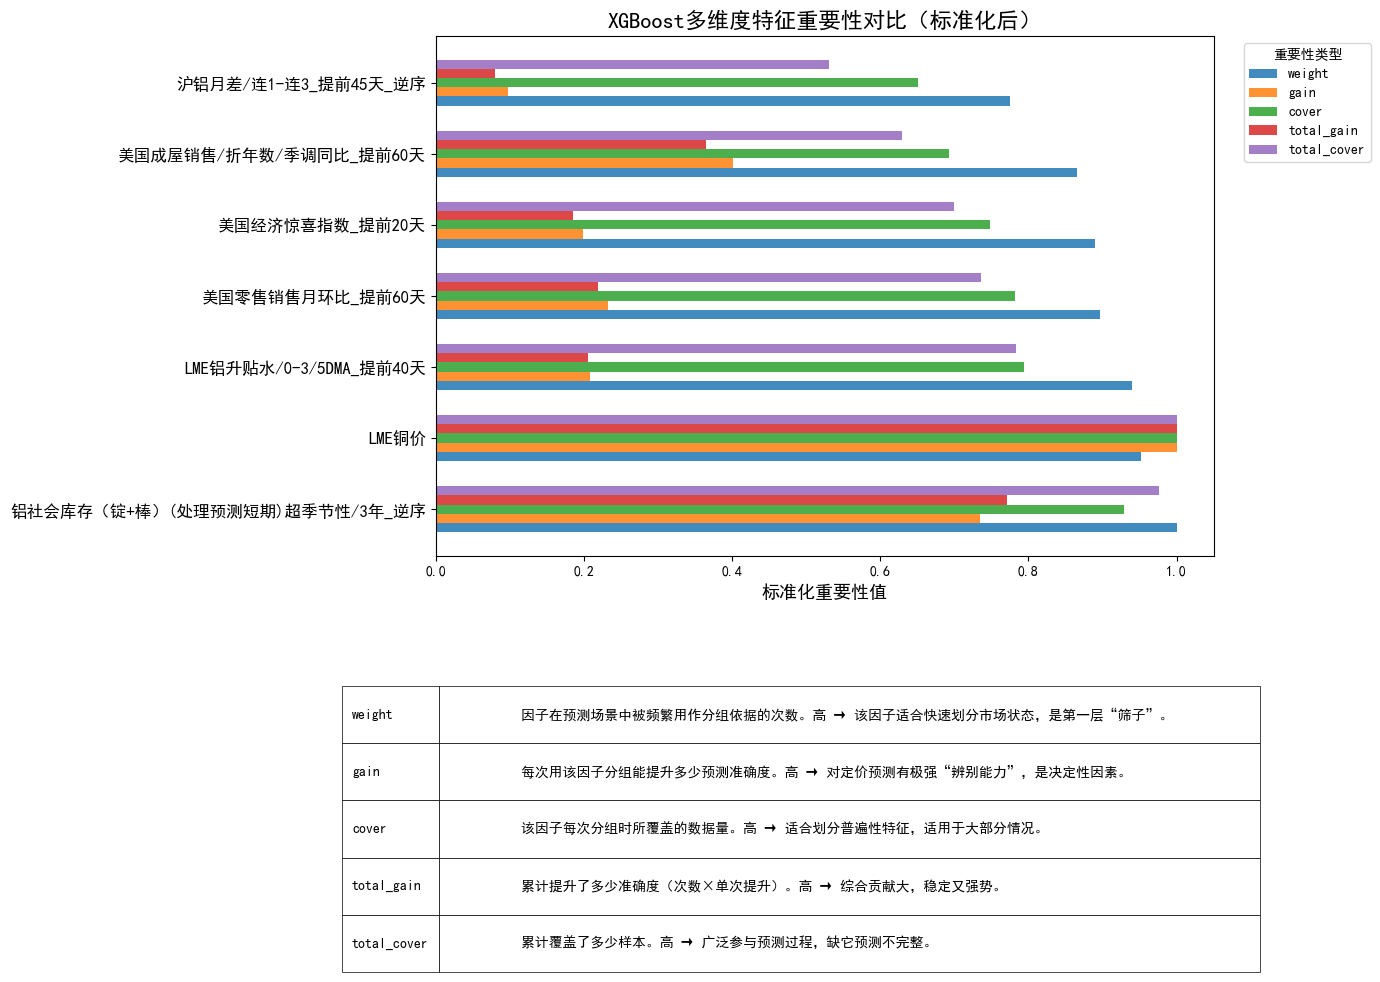

,weight,gain,cover,total_gain,total_cover
铝社会库存（锭+棒）(处理预测短期)超季节性/3年_逆序,1.000000,0.734326,0.929025,0.771220,0.975701
LME铜价,0.952161,1.000000,1.000000,1.000000,1.000000
LME铝升贴水/0-3/5DMA_提前40天,0.939232,0.207801,0.794205,0.204979,0.783420
美国零售销售月环比_提前60天,0.896564,0.232863,0.782152,0.219266,0.736483
美国经济惊喜指数_提前20天,0.889730,0.198771,0.747981,0.185738,0.698938
美国成屋销售/折年数/季调同比_提前60天,0.866088,0.401384,0.692603,0.365100,0.629993
沪铝月差/连1-连3_提前45天_逆序,0.775212,0.097631,0.651421,0.079487,0.530362


In [156]:
#绘制因子重要性
plot_xgb_feature_importance(model_all, X_train)


In [157]:
################################# 训练预测数据 excel格式输出  #################################

############ 日度 数据 ############
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})

historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})

merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/铁矿期货价格拟合残差_合并数据.xlsx', index=False,float_format='%.4f')         

############ 月度 数据 ############
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
test_pred_2024 = test_data[['Date', '预测值']].copy()
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 将真实值和预测值控制在5位有效数
merged_df_monthly['真实值'] = merged_df_monthly['真实值'].apply(lambda x: float(f'%.5g' % x))
merged_df_monthly['预测值'] = merged_df_monthly['预测值'].apply(lambda x: float(f'%.5g' % x))

merged_df_monthly.to_excel('eta/沪铝期货价格_月度数据.xlsx', index=False,float_format= '%.4f')       

In [158]:
merged_df_daily.head(30)

,Date,真实值,预测值
461,2025/11/28,NaN,21424.021484
460,2025/11/27,NaN,21383.529297
459,2025/11/26,NaN,21376.384766
458,2025/11/25,NaN,21377.031250
457,2025/11/24,NaN,21374.589844
456,2025/11/21,NaN,21376.500000
455,2025/11/20,NaN,21415.287109
454,2025/11/19,NaN,21421.228516
453,2025/11/18,NaN,21458.099609
452,2025/11/17,NaN,21417.826172


In [163]:
merged_df_daily['Date']

461    2025/11/28
460    2025/11/27
459    2025/11/26
458    2025/11/25
457    2025/11/24
          ...    
4      2024/01/08
3      2024/01/05
2      2024/01/04
1      2024/01/03
0      2024/01/02
Name: Date, Length: 462, dtype: object

In [159]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.铝_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "沪铝期货价格"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [160]:
from Lcel import update_excel_data
file_path = "eta/1.铝_数据上传.xlsx"
sheet_name = "详情页"
identifier = "沪铝期货价格"
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列
已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
